## Elevation Cleaning
---
This notebook smooths out the sampled elevation data

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
from shapely.ops import Point
from tqdm import tqdm
import pickle

from bikewaysim.paths import config
from bikewaysim.network import elevation_tools

## Import data

In [2]:
#import network
links = gpd.read_file(config['network_fp'] / f"osm.gpkg",layer='raw')

#reproject network to DEM crs
with (config['network_fp']/'dem_crs.txt').open('r') as fh:
    dem_crs = fh.read()
links.to_crs(dem_crs,inplace=True)

# import sampled elevation data
with (config['network_fp']/'elevation.pkl').open('rb') as fh:
    interpolated_points_dict = pickle.load(fh)

## Remove links if no elevation data found

In [3]:
#some below zero elevations near the airport
error = []
for linkid, item in interpolated_points_dict.items():
    if (item['elevations'] < 0).any():
        error.append(linkid)
print(len(error),'links with below zero elevations')

0 links with below zero elevations


In [4]:
# drop links with below zero elevations
interpolated_points_dict = {key:item for key,item in interpolated_points_dict.items() if key not in error}
links = links[links['osmid'].isin(interpolated_points_dict.keys())]

In [5]:
max_elev = np.max(np.array([item['elevations'].max() for key, item in interpolated_points_dict.items()]))
min_elev = np.min(np.array([item['elevations'].min() for key, item in interpolated_points_dict.items()]))
print('Max Elevation:',max_elev,'m','Min Elevation:',min_elev,'m')

Max Elevation: 328.6 m Min Elevation: 245.9 m


## Selected Examples
---
Examine some specific links to see what their grade profile looks like.

In [6]:
# linkid = 79424672
# grade_threshold = 10
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [7]:
# linkid = 42106698
# grade_threshold = 20
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [8]:
# linkid = 26800206
# grade_threshold = 20
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [9]:
# interpolated_points_dict[linkid] = elevation_tools.point_knockout(interpolated_points_dict[linkid],8)
# interpolated_points_dict[linkid]['elevations']
# linkid = 26800206
# grade_threshold = 8
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)
# x = interpolated_points_dict[linkid]['distances']
# y = interpolated_points_dict[linkid]['elevations']
# test = elevation_tools.elevation_stats(x,y,80)
# test.keys()
# test['descent_grade']
# test['bad_ascent_grades']
# test['bad_descent_grades']
# test['distance_deltas']

<!-- Local road that I know has steep grades: -->

In [10]:
# linkid = 340365816
# grade_threshold = 15
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True,lidar=True)

<!-- Northside Drive as "tertiary" road with a small segment above 15% -->

In [11]:
# linkid = 352003174
# grade_threshold = 15
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True,lidar=True)

<!-- Unpaved trail -->

In [12]:
# linkid = 1087991070
# grade_threshold = 30
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

<!-- BeltLine -->

In [13]:
# linkid = 226119768
# grade_threshold = 15
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [14]:
# linkid = 741964053
# grade_threshold = 30
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

<!-- Circular golf course loop -->

In [15]:
# linkid = 1087991070
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [16]:
# linkid = 569529892
# grade_threshold = 4
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True,lidar=True)

# Replace dem elevation values with lidar where available (OPTIONAL)

In [17]:
# for key, item in interpolated_points_dict.items():
#     if 'lidar' in item.keys():
#         lidar_elev = item['lidar']
#         dem_elev = item['elevations']
#         new_elev = [a if not np.isnan(a) else b for a, b in zip(lidar_elev,dem_elev)]
#         interpolated_points_dict[key]['elevations'] = np.array(new_elev)

# Point Knockout
- Calculate segment grades (rise/10m or rise/length if link length was less than 10m)
- Define a segment grade threshold by OSM highway type (e.g., motorway, local, secondary, etc.)
    - Highways/Interstates > 8%
    - Most local roads > 15%
    - Few local roads > 25%
- Knockout elevations where the associated grade changes exceeds the threshold
- Repeat until no grade changes are above the set threshold
    - If threshold is too low this will remove too many points
    - Just start and end will be used 
- Spline fit on the remaining data for the interpolation step

How it differs from Hongyu's Method:
- Find first grade change (ascent or descent) exceeding threshold
- Search 30m, 100m, or 150m after and find the last opposite grade change exceeding threshold
- Remove first to last point
- Infill with the spline fit
- Our segments are too short for this but this approach could be explored in the future

## Define Grade Thresholds
Don't set too high of a threshold

In [18]:
grade_thresholds = {
    'tunnel': 8,
    'bridge': 8,
    'roads': 8,
    'local': 20,
    'bikeped': 20,
    'everything_else': 25
}

In [19]:
#initialize the label field
links['label'] = None

#tunnel
links.loc[links['tunnel'].notna() & links['label'].isna(),'label'] = 'tunnel'

#bridge
links.loc[links['bridge'].notna() & links['label'].isna(),'label'] = 'bridge'

#motorway/major arterials
motorway = ['motorway','motorway_link',
            'trunk', 'trunk_link',
            'primary','primary_link',
            'secondary','secondary_link',
            'raceway', 'proposed','tertiary','tertiary_link','service', 'unclassified','living_street']
links.loc[links['highway'].isin(motorway) & links['label'].isna(),'label'] = 'roads'

#local/service roads
local = ['residential']
links.loc[links['highway'].isin(local) & links['label'].isna(),'label'] = 'local'

#pedestrian paths/steps may not follow grade thresholds
bikeped = ['path','footway','pedestrian','cycleway']
links.loc[links['highway'].isin(bikeped) & links['label'].isna(),'label'] = 'bikeped'

#label everything else as exclude or place a high value
links.loc[links['label'].isna(),'label'] = 'everything_else'

In [20]:
links['label'].value_counts()

label
bikeped            9566
roads              7118
local              1094
everything_else     500
bridge              292
tunnel              112
Name: count, dtype: int64

In [21]:
from importlib import reload
reload(elevation_tools)
for label, grade_threshold in grade_thresholds.items():
    #identify links with grades exceeding the threshold
    labelled_links = links.loc[links['label']==label,'osmid'].tolist()
    exceeds = elevation_tools.exceeds_threshold(labelled_links,interpolated_points_dict,grade_threshold)
    print(len(exceeds),'/',len(interpolated_points_dict),label,'links exceed the threshold')
    #for the links that exceed the threshold, do point knockout
    for linkid in tqdm(exceeds):
        item = interpolated_points_dict.get(linkid,0)
        item = elevation_tools.point_knockout(item,grade_threshold)
        interpolated_points_dict[linkid] = item
check = [key for key, item in interpolated_points_dict.items() if np.isnan(item['elevations']).any()]
print(len(check),'links had at least one point knocked out')

43 / 18682 tunnel links exceed the threshold


  0%|                                                                                                           | 0/43 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 840.48it/s]

195 / 18682 bridge links exceed the threshold


  0%|                                                                                                          | 0/195 [00:00<?, ?it/s]

 44%|█████████████████████████████████████████▊                                                      | 85/195 [00:00<00:00, 844.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 182/195 [00:00<00:00, 914.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 928.20it/s]

1453 / 18682 roads links exceed the threshold


  0%|                                                                                                         | 0/1453 [00:00<?, ?it/s]

  8%|██████▉                                                                                      | 109/1453 [00:00<00:01, 1085.53it/s]

 16%|██████████████▉                                                                              | 233/1453 [00:00<00:01, 1169.65it/s]

 25%|███████████████████████▎                                                                     | 365/1453 [00:00<00:00, 1235.72it/s]

 34%|████████████████████████████████                                                             | 500/1453 [00:00<00:00, 1276.96it/s]

 43%|████████████████████████████████████████▍                                                    | 632/1453 [00:00<00:00, 1291.80it/s]

 53%|█████████████████████████████████████████████████▋                                           | 776/1453 [00:00<00:00, 1341.94it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 915/1453 [00:00<00:00, 1355.19it/s]

 72%|██████████████████████████████████████████████████████████████████▌                         | 1051/1453 [00:00<00:00, 1296.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████▊                 | 1182/1453 [00:00<00:00, 1290.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▊        | 1323/1453 [00:01<00:00, 1326.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1453/1453 [00:01<00:00, 1306.01it/s]

18 / 18682 local links exceed the threshold


  0%|                                                                                                           | 0/18 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1257.79it/s]

276 / 18682 bikeped links exceed the threshold


  0%|                                                                                                          | 0/276 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████                                           | 150/276 [00:00<00:00, 1492.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:00<00:00, 1507.59it/s]

142 / 18682 everything_else links exceed the threshold


  0%|                                                                                                          | 0/142 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1716.91it/s]

2127 links had at least one point knocked out


Check some of the results

182529847
[287.9   nan]


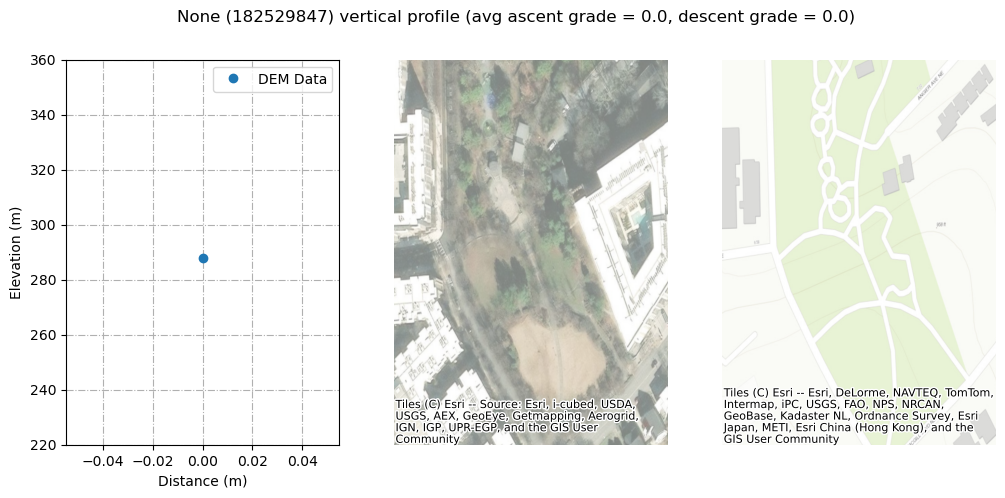

In [22]:
import random
linkid = random.choice(check)
print(linkid)
print(interpolated_points_dict[linkid]['elevations'])
grade_threshold = 10
elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,one_off=True)

Export into QGIS to examine

In [23]:
export = {linkid:elevation_tools.simple_elevation_stats(item['distances'],item['elevations']) for linkid, item in interpolated_points_dict.items()}
export = pd.DataFrame.from_dict(export,orient='index')

df = pd.merge(links,export,left_on='osmid',right_index=True)
df['ascent_ft'] = df['ascent_m'] * 3.28084
df['descent_ft'] = df['descent_m'] * 3.28084

df['max_grade'] = np.max(np.abs(df[['ascent_grade_%','descent_grade_%']].values),axis=1)
gdf = gpd.GeoDataFrame(df,crs=dem_crs)
gdf.to_crs(config['projected_crs_epsg'],inplace=True)
gdf.to_file(Path.home()/'Downloads/scratch.gpkg',layer='raw_grade')

In [24]:
# gdf[(gdf['ascent_m']>100) | (gdf['descent_m']>100)].explore()

In [25]:
gdf.loc[gdf['max_grade']>20].shape[0]

57

# Spline Fit
For all the links, fit a spline for the next step.

In [26]:
#spline fit
#TODO this step could be more advanced
import numpy as np
from scipy.interpolate import splrep, splev, BSpline

too_short = [ ]

for key, item in tqdm(interpolated_points_dict.items()):
    df = pd.DataFrame({'distance':item['distances'],'elevation':item['elevations']})

    #remove na values
    df = df[df.notna().all(axis=1)]

    #in this case, just do linear interpolation between the two values
    if df.shape[0] <= 3:
        too_short.append(key)
        continue

    #fit a spline
    spline = splrep(df['distance'], df['elevation'], s=0.5)

    #add spline to dict
    interpolated_points_dict[key]['spline'] = spline

    #TODO add this feature
    #get smoothed elevations

  0%|                                                                                                        | 0/18682 [00:00<?, ?it/s]

  4%|███▌                                                                                        | 726/18682 [00:00<00:02, 7253.69it/s]

  8%|███████▍                                                                                   | 1523/18682 [00:00<00:02, 7672.86it/s]

 13%|███████████▍                                                                               | 2338/18682 [00:00<00:02, 7890.52it/s]

 17%|███████████████▍                                                                           | 3182/18682 [00:00<00:01, 8107.21it/s]

 21%|███████████████████▍                                                                       | 3996/18682 [00:00<00:01, 8115.82it/s]

 26%|███████████████████████▌                                                                   | 4835/18682 [00:00<00:01, 8207.75it/s]

 31%|███████████████████████████▊                                                               | 5709/18682 [00:00<00:01, 8379.15it/s]

 35%|████████████████████████████████                                                           | 6579/18682 [00:00<00:01, 8480.84it/s]

 40%|████████████████████████████████████▎                                                      | 7444/18682 [00:00<00:01, 8531.82it/s]

 44%|████████████████████████████████████████▍                                                  | 8298/18682 [00:01<00:01, 8438.25it/s]

 49%|████████████████████████████████████████████▌                                              | 9143/18682 [00:01<00:01, 8428.97it/s]

 53%|████████████████████████████████████████████████▋                                          | 9987/18682 [00:01<00:01, 8294.66it/s]

 58%|████████████████████████████████████████████████████▏                                     | 10822/18682 [00:01<00:00, 8309.68it/s]

 62%|████████████████████████████████████████████████████████▏                                 | 11669/18682 [00:01<00:00, 8357.51it/s]

 67%|████████████████████████████████████████████████████████████▎                             | 12518/18682 [00:01<00:00, 8395.17it/s]

 72%|████████████████████████████████████████████████████████████████▎                         | 13358/18682 [00:01<00:00, 8396.31it/s]

 76%|████████████████████████████████████████████████████████████████████▍                     | 14198/18682 [00:01<00:00, 8271.87it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                 | 15026/18682 [00:01<00:00, 8179.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████▎             | 15845/18682 [00:01<00:00, 8129.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▍         | 16704/18682 [00:02<00:00, 8262.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 17540/18682 [00:02<00:00, 8289.32it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 18378/18682 [00:02<00:00, 8314.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 18682/18682 [00:02<00:00, 8263.84it/s]

In [27]:
print(len(too_short))

10175


In [28]:
interpolated_points_dict[too_short[3]]

{'geometry': array([[ 741674.05911429, 3742958.16546251],
        [ 741680.69960044, 3742965.64235649],
        [ 741684.9217291 , 3742974.69912576]]),
 'distances': array([ 0, 10, 20]),
 'elevations': array([276. , 275.5, 274.9])}

In [29]:
# links[links['osmid'].isin(too_short)].explore()

In [30]:
with (config['network_fp'] / "spline_fit_elevation.pkl").open('wb') as fh:
    pickle.dump(interpolated_points_dict,fh)